# Trip duration prediction model

At some point or the other almost each one of us has used an Ola or Uber for taking a ride.

<p align = "center"> <img  src = "./Uber.jpg" alt = "New York City Taxi Uber">
</p>

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

To improve the efficiency of taxi dispatching systems for such services, it's important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

## Recall of features

> #### Initial Features

| **`Columns`**        | **`Description`**  |  
| ------------- |-------------:|
| id  | A unique identifier for each trip|
| vendor_id |A code indicating the provider associated with the trip record|
| pickup_datetime| Date and time when the meter was engaged|
| dropoff_datetime| Date and time when the meter was disengaged|
|passenger_count|Number of passengers in vehicle during trip|
| pickup_latitude |Pickup location Latitude|
| pickup_longitude |  Pickup location Longitude|
| dropoff_latitude    | Dropoff location latitude  |
| dropoff_longitude     | Dropoff location longitude|
| store_and_fwd_flag |This flag indicated whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y for yes / N for no )|
| trip_duration  | Duration of Trip |

> ### After Assessing and EDA

| **`Columns`**        | **`Description`**  |  
| ------------- |-------------:|
| passenger_count |Number of passengers in vehicle during trip|
| trip_duration  | Duration of Trip |
|month_pickup_datetime|Month of pickup extracted from pickup datetime feature|
|hour_pickup_datetime|Hour of pickup extracted from pickup datetime feature|
|day_pickup_datetime|Day of pickup extracted from pickup datetime feature|
|month_dropoff_datetime|Month of Dropoff extracted from Dropoff datetime feature|
|hour_dropoff_datetime|Hour of Dropoff extracted from Dropoff datetime feature|
|day_dropoff_datetime|Day of Dropoff extracted from Dropoff datetime feature|
|Distance_pick_drop | Distance computed for trip|
|day_moments| Moments of day (Morning, afternoon, evening,...)|
|distance_slots|short or long distance|

> ### Full summary of EDA

* There is similar relation between the pickup and dropoff moments.
* The outliers are in number in data. We should manage them to justify the pickup and dropoff moments.
* We removed from data , trips without passengers.
* Too many variables with insignificant correlation.But the day, month and hour of pickups are highly correlated to those of dropoff.
* The distance_pick_drop is moderately correlated to trip duration by referring to Spearman comparison.
* The difference between the distances by day moments is very significant.
* The difference between the number of passengers by day moments is very significant. We can see that most of long distance are made during evening by taxi having between 2 and 4 passengers. As the distance increases, the number of passengers decreases.
* The difference between the trip duration during day and by night is significant. Also between trip duration for evening and middle morning, and also between all others day moments. 
* As expected the trip duration increases with the distance traveled.
* The difference between the trip distance with 1 and more passengers is significant. The difference between the trip duration with 2 passengers and 3 up to 4 passengers is not significant. But from 5 passengers the trip duration decreases significantly compared to with 2, 3, 4. Therefore the difference between taxi travel time with 5 and 6 passengers is not significant.


## Loading Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score,median_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Loading Data

In [2]:
df = pd.read_csv('./trip_data.csv')

In [3]:
df.head()

,passenger_count,trip_duration,day_pickup_datetime,month_pickup_datetime,hour_pickup_datetime,day_dropoff_datetime,month_dropoff_datetime,hour_dropoff_datetime,Distance_pick_drop,day_moments,distance_slots
0,1,400.0,29,2,16,29,2,16,1.199073,Afternoon,Shortest_distance
1,2,1100.0,11,3,23,11,3,23,4.129111,Evening,Long_distance
2,2,1635.0,21,2,17,21,2,18,7.250753,Afternoon,Long_distance
3,6,1141.0,5,1,9,5,1,10,2.361097,Early_morning,Shortest_distance
4,1,848.0,17,2,6,17,2,6,4.328534,Early_morning,Long_distance


In [4]:
df.dtypes

passenger_count             int64
trip_duration             float64
day_pickup_datetime         int64
month_pickup_datetime       int64
hour_pickup_datetime        int64
day_dropoff_datetime        int64
month_dropoff_datetime      int64
hour_dropoff_datetime       int64
Distance_pick_drop        float64
day_moments                object
distance_slots             object
dtype: object

In [5]:
df.describe(include='O')

,day_moments,distance_slots
count,726075,726075
unique,5,2
top,Evening,Shortest_distance
freq,249177,477794


### Preprocessing

Now, before applying linear model such as logistic regression and others, we need to scale the data and keep all features as numeric strictly. 


### Dummies with Multiple Categories

In [6]:
# Convert categorical variables to one hot encoded features
cat_vars = ['passenger_count','day_moments','distance_slots']
for el in cat_vars:
    df = pd.concat([df,pd.get_dummies(df[el],prefix = str(el),prefix_sep='_')],axis = 1)
df.head()

,passenger_count,trip_duration,day_pickup_datetime,month_pickup_datetime,hour_pickup_datetime,day_dropoff_datetime,month_dropoff_datetime,hour_dropoff_datetime,Distance_pick_drop,day_moments,...,passenger_count_5,passenger_count_6,passenger_count_7,day_moments_Afternoon,day_moments_Early_morning,day_moments_Evening,day_moments_Full_night,day_moments_Middle_morning,distance_slots_Long_distance,distance_slots_Shortest_distance
0,1,400.0,29,2,16,29,2,16,1.199073,Afternoon,...,0,0,0,1,0,0,0,0,0,1
1,2,1100.0,11,3,23,11,3,23,4.129111,Evening,...,0,0,0,0,0,1,0,0,1,0
2,2,1635.0,21,2,17,21,2,18,7.250753,Afternoon,...,0,0,0,1,0,0,0,0,1,0
3,6,1141.0,5,1,9,5,1,10,2.361097,Early_morning,...,0,1,0,0,1,0,0,0,0,1
4,1,848.0,17,2,6,17,2,6,4.328534,Early_morning,...,0,0,0,0,1,0,0,0,1,0


(array([ 50659., 146457., 144868., 111909.,  81814.,  56273.,  39099.,
         26903.,  18511.,  49582.]),
 array([1.00000e+00, 2.10450e+02, 4.19900e+02, 6.29350e+02, 8.38800e+02,
        1.04825e+03, 1.25770e+03, 1.46715e+03, 1.67660e+03, 1.88605e+03,
        2.09550e+03]),
 <BarContainer object of 10 artists>)

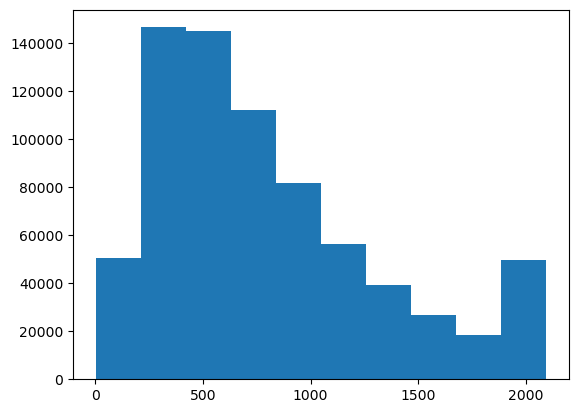

In [7]:
# Before scale numerical features let's see one more time its distribution
plt.hist(df.trip_duration)

(array([ 68558., 191385., 142337.,  88973.,  55760.,  37122.,  26657.,
         19993.,  14716.,  80574.]),
 array([1.06156854e-03, 7.87455412e-01, 1.57384925e+00, 2.36024310e+00,
        3.14663694e+00, 3.93303078e+00, 4.71942463e+00, 5.50581847e+00,
        6.29221231e+00, 7.07860616e+00, 7.86500000e+00]),
 <BarContainer object of 10 artists>)

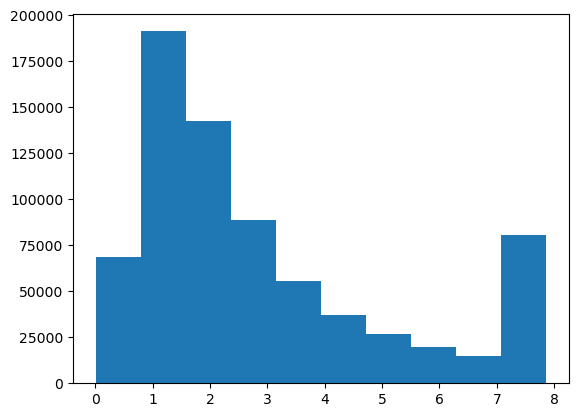

In [8]:
plt.hist(df.Distance_pick_drop)

In [9]:
print(df[['trip_duration','Distance_pick_drop']].describe())
print(df[['trip_duration','Distance_pick_drop']].skew())

       trip_duration  Distance_pick_drop
count  726075.000000       726075.000000
mean      802.864444            2.916481
std       528.874250            2.247042
min         1.000000            0.001062
25%       398.000000            1.242392
50%       664.000000            2.105738
75%      1077.000000            3.889779
max      2095.500000            7.865000
trip_duration         0.969453
Distance_pick_drop    1.100163
dtype: float64


The two numerical distributions are similar and strongly skewed at right.

df = pd.read_csv('./trip_data.csv')

### Scaling Numerical Features for Logistic Regression

* Log Transformation
* Standard Scaler

Standard scaling is anyways a necessity when it comes to linear models and we have done that here after doing log transformation on all numerical features.

In [10]:
num_cols = ['Distance_pick_drop']
for i in num_cols:
    df[i] = np.log(df[i]+10)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

(array([ 33635., 145164., 148321., 108733.,  73403.,  50028.,  35770.,
         26699.,  20084.,  84238.]),
 array([-1.49309175, -1.13522592, -0.77736009, -0.41949427, -0.06162844,
         0.29623739,  0.65410321,  1.01196904,  1.36983486,  1.72770069,
         2.08556652]),
 <BarContainer object of 10 artists>)

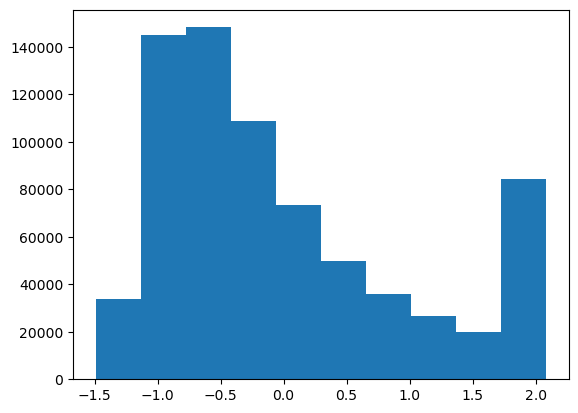

In [11]:
plt.hist(scaled.Distance_pick_drop)

In [12]:
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [13]:
y_all = df.trip_duration

## Model Building and Evaluation Metrics
Since this is a regression problem, we could use the following 2 metrics:

1. Mean Squared Error
2. Adjusted R²

We want to predict with good precision the trip duration. If the estimate time for a trip is more than reality that will not a matter but the reverse could discredit the taxi services.So we want reduce at maximum FP( False positive). As we are facing a regression problem the more suitable metrics are MSE/MAE or R²/Adjusted R².




### Conclusions from EDA
* The distance_pick_drop is moderately correlated to trip duration by referring to Spearman comparison.
* The difference between the trip duration during day and by night is significant. Also between trip duration for evening and middle morning, and also between all others day moments. 
* As expected the trip duration increases with the distance traveled.
* The difference between the trip distance with 1 and more passengers is significant. The difference between the trip duration with 2 passengers and 3 up to 4 passengers is not significant. But from 5 passengers the trip duration decreases significantly compared to with 2, 3, 4. Therefore the difference between taxi travel time with 5 and 6 passengers is not significant.

Now, we will first split our dataset into test and train and using the above conclusions select columns and build a baseline logistic regression model to check the MSE Score & the R² score.


### Baseline Columns

In [14]:
df.columns

Index(['passenger_count', 'trip_duration', 'day_pickup_datetime',
       'month_pickup_datetime', 'hour_pickup_datetime', 'day_dropoff_datetime',
       'month_dropoff_datetime', 'hour_dropoff_datetime', 'day_moments',
       'distance_slots', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'passenger_count_7', 'day_moments_Afternoon',
       'day_moments_Early_morning', 'day_moments_Evening',
       'day_moments_Full_night', 'day_moments_Middle_morning',
       'distance_slots_Long_distance', 'distance_slots_Shortest_distance',
       'Distance_pick_drop'],
      dtype='object')

In [15]:
df.dtypes

passenger_count                       int64
trip_duration                       float64
day_pickup_datetime                   int64
month_pickup_datetime                 int64
hour_pickup_datetime                  int64
day_dropoff_datetime                  int64
month_dropoff_datetime                int64
hour_dropoff_datetime                 int64
day_moments                          object
distance_slots                       object
passenger_count_1                     uint8
passenger_count_2                     uint8
passenger_count_3                     uint8
passenger_count_4                     uint8
passenger_count_5                     uint8
passenger_count_6                     uint8
passenger_count_7                     uint8
day_moments_Afternoon                 uint8
day_moments_Early_morning             uint8
day_moments_Evening                   uint8
day_moments_Full_night                uint8
day_moments_Middle_morning            uint8
distance_slots_Long_distance    

In [16]:
baseline_cols = ['day_pickup_datetime', 'month_pickup_datetime',
       'hour_pickup_datetime', 'day_dropoff_datetime',
       'month_dropoff_datetime', 'hour_dropoff_datetime','passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'passenger_count_7', 'day_moments_Afternoon',
       'day_moments_Early_morning', 'day_moments_Evening',
       'day_moments_Full_night', 'day_moments_Middle_morning',
       'distance_slots_Long_distance', 'distance_slots_Shortest_distance',
       'Distance_pick_drop']

In [17]:
df_baseline = df[baseline_cols]

### Train Test Split to create a validation set

In [18]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=64, stratify = y_all)

In [19]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae, r2_score, mean_squared_error as mse
LinReg = LR()
LinReg.fit(xtrain,ytrain)

LinearRegression()

In [20]:
# Predicting on the train set
train_predict = LinReg.predict(xtrain)
k = mae(train_predict,ytrain)
print('Training Mean Absolute Error: ',k)
# Predicting on the test set
test_predict = LinReg.predict(xtest)
kt = mae(test_predict,ytest)
print('Testing Mean Absolute Error: ',kt)
print('R2_Score for this baseline model:',r2_score(test_predict,ytest))
print('MSE for model: ', mse(test_predict,ytest))

Training Mean Absolute Error:  226.6976252824783
Testing Mean Absolute Error:  226.79795011806277
R2_Score for this baseline model: 0.5111359762894643
MSE for model:  91175.45053509763


In [21]:
#Parameters of linear Regression
LinReg.coef_

array([-1.06201138e+03, -3.23569562e+04, -5.85897035e+01,  1.06241171e+03,
        3.23699237e+04,  4.72921372e+01, -1.28863906e+01,  3.02333893e+00,
        1.18055388e+01,  1.34988574e+01, -8.49745172e+00, -6.94389280e+00,
       -6.54267751e-10,  1.50837906e+02, -4.52212639e+01,  8.47326390e+01,
       -2.84946594e+02,  9.45973127e+01, -1.55342382e+01,  1.55342382e+01,
        4.35459244e+02])

Text(0.5, 1.0, 'Coefficients plot')

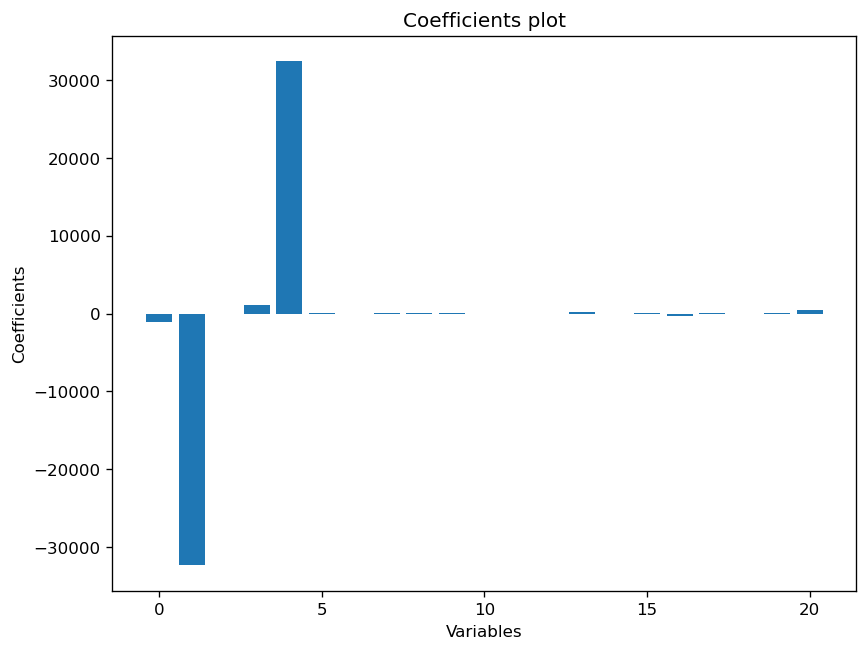

In [22]:
# Plotting the coefficients
plt.figure(figsize = (8,6),dpi = 120, facecolor='w', edgecolor='b' )
x = range(len(xtrain.columns))
y = LinReg.coef_
plt.bar(x,y)
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.title('Coefficients plot')

In [23]:
# Test set predicting
test_predict = LinReg.predict(xtest)

# Checking Assumptions of Linear Model
residuals = pd.DataFrame({
    'fitted_values' : ytest,
    'predicted_values': test_predict
})
residuals['residuals'] = residuals['fitted_values'] - residuals['predicted_values']
residuals.head()

,fitted_values,predicted_values,residuals
691198,734.0,433.113161,300.886839
117648,711.0,845.994408,-134.994408
288316,759.0,983.221585,-224.221585
179599,1067.0,1079.985911,-12.985911
244373,401.0,513.218108,-112.218108


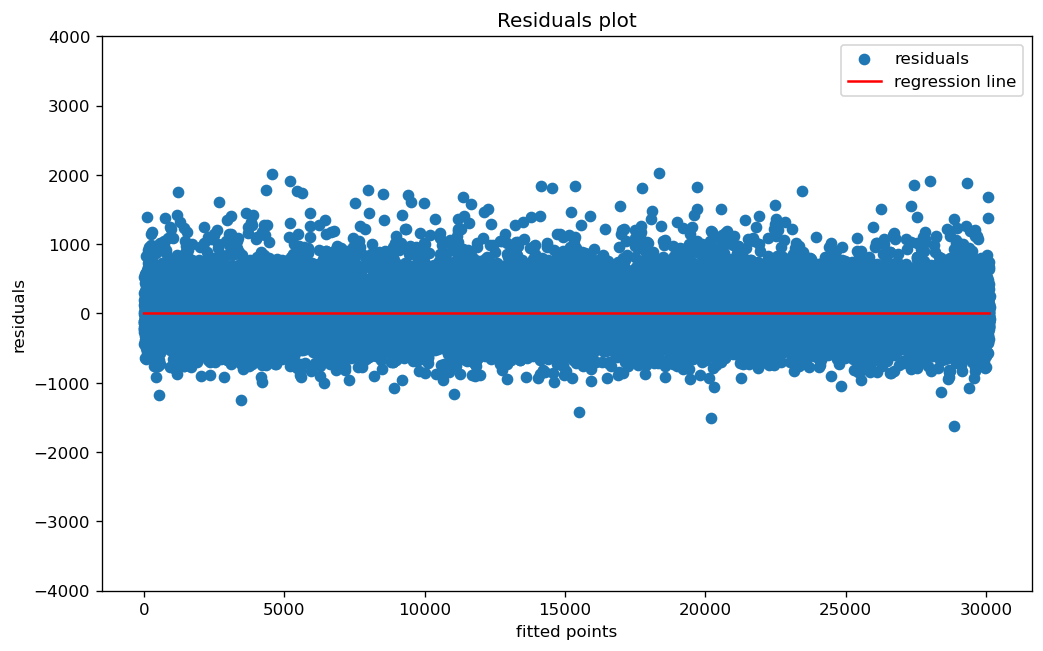

In [24]:
# Plotting residual curve (Is these constant variance or homoscedastic)

plt.figure(figsize =(10,6), dpi =120, facecolor='w',edgecolor='b')
f = range(0,30131)
k = [0 for i in range (0,30131)]
plt.scatter(f, residuals.residuals[:30131],label = 'residuals')
plt.plot(f, k, color = 'red',label = 'regression line')
plt.xlabel('fitted points')
plt.ylabel('residuals')
plt.title('Residuals plot')
plt.ylim(-4000,4000)
plt.legend()

There is homoscedasticity of residual variance.

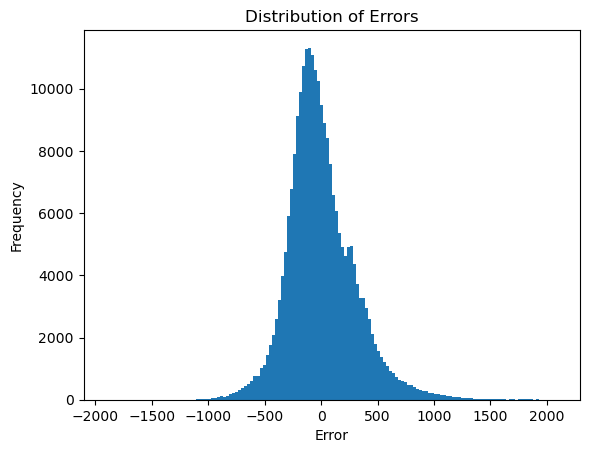

In [25]:
# Normality checking for residuals
plt.hist(residuals.residuals, bins = 150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.show()

The errors follow a normal distribution but roughly skewed.

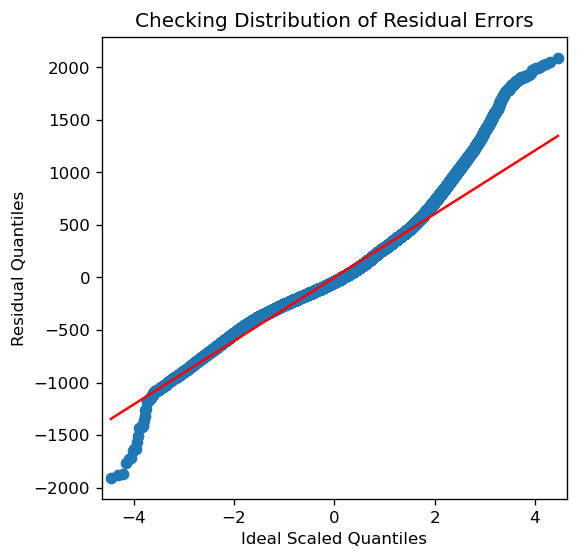

In [26]:
# QQ Plot (Is the data normally distributed?)
from statsmodels.graphics.gofplots import qqplot

# Plotting the QQ Plot
fig , ax = plt.subplots(figsize = (5,5), dpi = 120)
qqplot(residuals.residuals, line = 's', ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking Distribution of Residual Errors')
plt.show()

In [27]:
from scipy.stats import shapiro
shapiro(residuals.residuals)

ShapiroResult(statistic=0.9619317054748535, pvalue=0.0)

The distribution is not normal by refering on Shapiro wilk test and QQ plot, we have a lot of outliers on low and high values. Let's verify if there is multi colinearity between some variables.


### Variance Inflation Factor (VIF) (Checking for multi collinearity)

In [28]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF for every column (only works for the not Catagorical)
VIF = pd.Series([variance_inflation_factor(df_baseline.values, i) for i in range(df_baseline.shape[1])], index =df_baseline.columns)
VIF

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


day_pickup_datetime                 3.176051e+04
month_pickup_datetime               1.085259e+06
hour_pickup_datetime                5.341401e+01
day_dropoff_datetime                3.175986e+04
month_dropoff_datetime              1.085443e+06
hour_dropoff_datetime               3.876070e+01
passenger_count_1                            inf
passenger_count_2                            inf
passenger_count_3                            inf
passenger_count_4                            inf
passenger_count_5                            inf
passenger_count_6                            inf
passenger_count_7                            inf
day_moments_Afternoon                        inf
day_moments_Early_morning                    inf
day_moments_Evening                          inf
day_moments_Full_night                       inf
day_moments_Middle_morning                   inf
distance_slots_Long_distance                 inf
distance_slots_Shortest_distance             inf
Distance_pick_drop  

The moments of pickup and dropoff seems have multicolinearity. So these independent variables should be removed from linear model.

In [29]:
final_cols = ['month_pickup_datetime',
       'day_dropoff_datetime','passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'passenger_count_7', 'day_moments_Afternoon',
       'day_moments_Early_morning', 'day_moments_Evening',
       'day_moments_Full_night', 'day_moments_Middle_morning',
       'distance_slots_Long_distance', 'distance_slots_Shortest_distance',
       'Distance_pick_drop']
data = df[final_cols]
#data = df[baseline_cols]

In [30]:
# Let's normalize the data for model
from sklearn.preprocessing import MinMaxScaler as min_max
data = min_max().fit_transform(data)
data = pd.DataFrame(data, columns = final_cols)
#data = pd.DataFrame(data, columns = baseline_cols)
y_all = min_max().fit_transform(np.array(df['trip_duration']).reshape(-1, 1))
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(data,y_all,test_size=1/4, random_state=86, stratify = y_all)
LinReg.fit(xtrain,ytrain)

LinearRegression()

In [31]:
data.head()

,month_pickup_datetime,day_dropoff_datetime,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,day_moments_Afternoon,day_moments_Early_morning,day_moments_Evening,day_moments_Full_night,day_moments_Middle_morning,distance_slots_Long_distance,distance_slots_Shortest_distance,Distance_pick_drop
0,0.2,0.933333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.195017
1,0.4,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.595613
2,0.2,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.939692
3,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.365185
4,0.2,0.533333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.619771


In [32]:
y_all.shape

(726075, 1)

In [33]:
# Predicting on the train set
train_predict = LinReg.predict(xtrain)
k = mae(train_predict,ytrain)
print('Training Mean Absolute Error: ',k)
# Predicting on the test set
test_predict = LinReg.predict(xtest)
kt = mae(test_predict,ytest)
print('Testing Mean Absolute Error: ',kt)
print('R2_Score for model :',r2_score(test_predict,ytest))
print('MSE for model: ', mse(test_predict,ytest))

Training Mean Absolute Error:  0.11053324469468302
Testing Mean Absolute Error:  0.11013186061856624
R2_Score for model : 0.4851574043925445
MSE for model:  0.021619128760334987


In [34]:
LinReg.coef_

array([[ 3.17729310e-02,  4.67185344e-03, -2.76435543e+11,
        -2.76435543e+11, -2.76435543e+11, -2.76435543e+11,
        -2.76435543e+11, -2.76435543e+11, -2.76435543e+11,
         7.24819998e+11,  7.24819998e+11,  7.24819998e+11,
         7.24819998e+11,  7.24819998e+11, -1.67361259e+08,
        -1.67361259e+08,  7.52716249e-01]])

Text(0.5, 1.0, 'Normalized Coefficient plot')

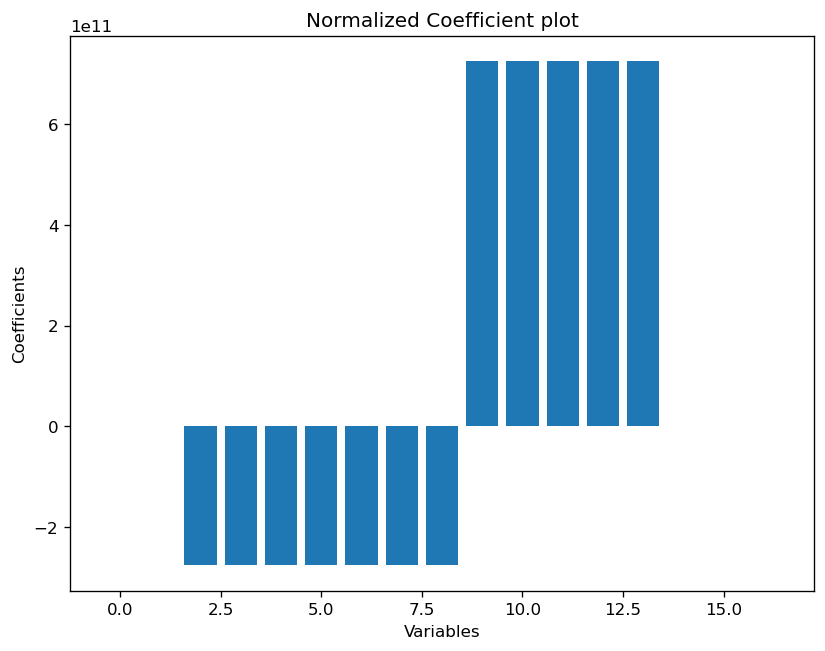

In [35]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(xtrain.columns))
y = LinReg.coef_[0]
plt.bar( x, y )
plt.xlabel( "Variables")

plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

In [36]:
Coefficients = pd.DataFrame({
    'Variable'    : xtrain.columns,
    'coefficient' : LinReg.coef_[0]
})
Coefficients

,Variable,coefficient
0,month_pickup_datetime,3.177293e-02
1,day_dropoff_datetime,4.671853e-03
2,passenger_count_1,-2.764355e+11
3,passenger_count_2,-2.764355e+11
4,passenger_count_3,-2.764355e+11
5,passenger_count_4,-2.764355e+11
6,passenger_count_5,-2.764355e+11
7,passenger_count_6,-2.764355e+11
8,passenger_count_7,-2.764355e+11
9,day_moments_Afternoon,7.248200e+11


In [37]:
# Calculating VIF for every column (only works for the not Catagorical)
VIF = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index =data.columns)
VIF

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


month_pickup_datetime               1.000850
day_dropoff_datetime                1.000374
passenger_count_1                        inf
passenger_count_2                        inf
passenger_count_3                        inf
passenger_count_4                        inf
passenger_count_5                        inf
passenger_count_6                        inf
passenger_count_7                        inf
day_moments_Afternoon                    inf
day_moments_Early_morning                inf
day_moments_Evening                      inf
day_moments_Full_night                   inf
day_moments_Middle_morning               inf
distance_slots_Long_distance             inf
distance_slots_Shortest_distance         inf
Distance_pick_drop                  3.743380
dtype: float64

Compared to preview model, this new looks better especially on MAE and MSE metrics. Let's try with Ridge and Lasso if that could improve model performance.

In [38]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


In [39]:
Elastic_Net_regression ={
    'alpha':[i for i in range(1,10)],
    'l1_ratio':[i for i in np.arange(0,1,0.05)]

    
}
#,'neg_mean_absolute_error','r2'
clf = GridSearchCV(ElasticNet(), param_grid=Elastic_Net_regression,scoring='neg_mean_squared_error',cv=5)
clf.fit(data, y_all)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'l1_ratio': [0.0, 0.05, 0.1, 0.15000000000000002, 0.2,
                                      0.25, 0.30000000000000004,
                                      0.35000000000000003, 0.4, 0.45, 0.5, 0.55,
                                      0.6000000000000001, 0.65,
                                      0.7000000000000001, 0.75, 0.8,
                                      0.8500000000000001, 0.9,
                                      0.9500000000000001]},
             scoring='neg_mean_squared_error')

In [40]:
print(clf.best_score_,clf.best_params_,)

-0.0457884147753032 {'alpha': 1, 'l1_ratio': 0.0}


In [41]:
clf = GridSearchCV(ElasticNet(), param_grid=Elastic_Net_regression,scoring='neg_mean_absolute_error',cv=5)
clf.fit(data, y_all)
print(clf.best_score_,clf.best_params_,)

-0.16882447083635824 {'alpha': 1, 'l1_ratio': 0.0}


In [42]:
clf = GridSearchCV(ElasticNet(), param_grid=Elastic_Net_regression,scoring='r2',cv=5)
clf.fit(data, y_all)
print(clf.best_score_,clf.best_params_,)

0.2818543019628016 {'alpha': 1, 'l1_ratio': 0.0}


The ElasticNEt model which combine the Ridge and lasso seems give good results based on MAE and MSE but not better than our previous model.

So our best model remains the previous model based on normal linar regression.